In [55]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# !export PYTHONPATH=/Users/piyush/projects/ViDA-SSL/
import sys
from os.path import abspath, join, dirname

sys.path.append(dirname(dirname(abspath("."))))

In [3]:
from os.path import join
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from scipy.special import softmax
from sklearn.manifold import TSNE
from glob import glob
from subprocess import call

import torch
import torch.nn.functional as F

from datasets.ntu import NTU
from datasets.epic import EPIC
from datasets.something_something import SomethingSomething
from datasets.finegym import FineGym
from datasets.ucf import UCF
from datasets.kinetics import Kinetics

In [4]:
import torchvision
from torchvision import transforms

from image_utils import show_single_image, show_multiple_images

In [5]:
np.random.seed(0)

In [6]:
import warnings
warnings.simplefilter("ignore")

In [19]:
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif",
#     "font.serif": ["Computer Modern Roman"],
# })

### Sample

In [8]:
data_root = "/ssd/fmthoker/gym"
video_dir = join(data_root, "subactions")

In [9]:
annot_file = join(data_root, "annotations/gym99_train.txt")
df = pd.read_csv(annot_file, header=None)
df["video_name"] = df[0].apply(lambda x: x.split(" ")[0])
df["class"] = df[0].apply(lambda x: x.split(" ")[1])
del df[0]

In [10]:
df

,video_name,class
0,A0xAXXysHUo_E_002184_002237_A_0035_0036.avi,93
1,AZ4wWG6Rcak_E_003643_003675_A_0024_0026.avi,77
2,AZ4wWG6Rcak_E_004073_004175_A_0053_0054.avi,43
3,AZ4wWG6Rcak_E_004073_004175_A_0054_0055.avi,55
4,AZ4wWG6Rcak_E_004073_004175_A_0061_0062.avi,43
...,...,...
20479,zfqS-wCJSsw_E_000756_000763_A_0000_0007.avi,1
20480,zfqS-wCJSsw_E_000938_000947_A_0001_0008.avi,3
20481,zfqS-wCJSsw_E_001328_001335_A_0001_0007.avi,1
20482,zfqS-wCJSsw_E_005719_005727_A_0000_0007.avi,4


In [11]:
df[df["class"] == "2"]

,video_name,class
2476,GF8D7Dx2mhs_E_007697_007706_A_0000_0008.avi,2
2702,Gng3ezTNGog_E_000532_000540_A_0000_0007.avi,2
2894,HubzmiNVVXs_E_003015_003023_A_0000_0007.avi,2
2895,HubzmiNVVXs_E_003015_003022_A_0000_0007.avi,2
2897,HubzmiNVVXs_E_003359_003366_A_0000_0007.avi,2
...,...,...
20456,zNL3kn3UBmg_E_006402_006411_A_0000_0006.avi,2
20457,zNL3kn3UBmg_E_006691_006700_A_0002_0008.avi,2
20458,zNL3kn3UBmg_E_006999_007007_A_0000_0007.avi,2
20478,zfqS-wCJSsw_E_000674_000682_A_0000_0007.avi,2


### Sample from subset `FX-S1`

In [12]:
class_to_idx = {
    "Switch leap with 0.5 turn": "6",
    "Switch leap with 1 turn": "7",
}

Switch leap with 0.5 turn


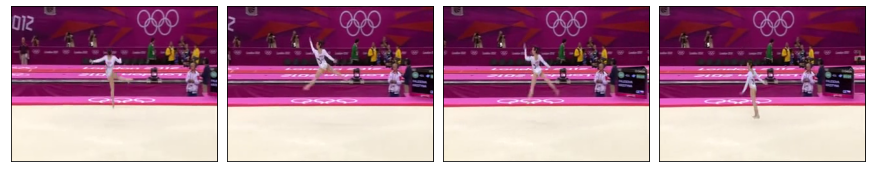

Switch leap with 1 turn


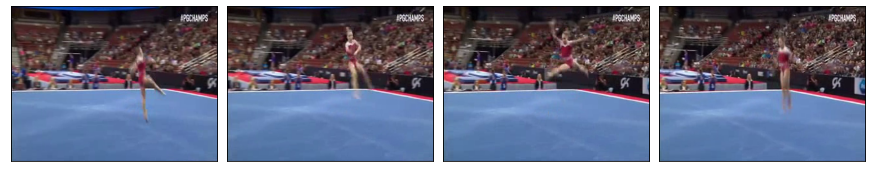

In [69]:
sampled_videos = []
sampled_class_text = []
sampled_class_id = []

for class_text, class_id in class_to_idx.items():
    subdf = df[df["class"] == class_id]
    
    videos = subdf.video_name.values
    sampled_video = np.random.choice(videos, 1, replace=False)
    sampled_videos.extend(list(sampled_video))
    sampled_class_text.append(class_text)
    sampled_class_id.append(class_id)
    
    # visualize frames from sampled video
    frames, _, metadata = torchvision.io.read_video(join(video_dir, sampled_video[0]))

    num_frames = 4

    # selected_frames = np.random.randint(0, len(frames) - 1, size=num_frames)
    selected_frame_indices = [5, 10, 15, 20]
    selected_frames = frames[selected_frame_indices]
    print(class_text)

    class_name = class_text.replace(" ", "_")
    show_multiple_images(
        selected_frames, normalized=False, title="", figsize=(12, 4),
        save=True, path=f"image-samples/gym99-{class_name}-{class_id}.pdf"
    )

### Sample from two semantically different classes

In [32]:
exclude = [6,7,8,9,10,11,12,13,14,15,16] + list(range(74,89))
exclude = [str(x) for x in exclude]

In [37]:
videos = list(df[~df["class"].isin(exclude)].video_name.values)
classes = list(df[~df["class"].isin(exclude)]["class"].values)

5


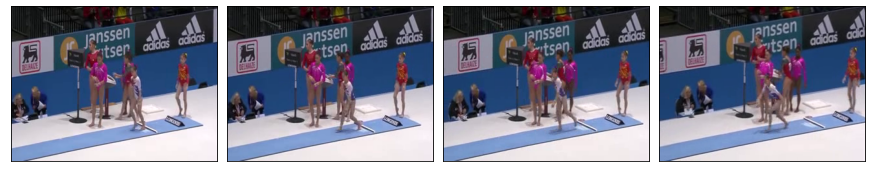

In [56]:
idx = np.random.choice(range(len(videos)))
sampled_video = videos[idx]

# visualize frames from sampled video
frames, _, metadata = torchvision.io.read_video(join(video_dir, sampled_video))

# selected_frames = np.random.randint(0, len(frames) - 1, size=num_frames)
selected_frame_indices = [5, 10, 15, 20]
selected_frames = frames[selected_frame_indices]
print(classes[idx])

class_name = class_text.replace(" ", "_")
show_multiple_images(
    selected_frames, normalized=False, title="", figsize=(12, 4),
    save=True, path=f"image-samples/gym99-{classes[idx]}.pdf"
)